# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [32]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [33]:
from torch.utils.data import random_split

# Define transforms
transforms = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.75),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Create training set and define training dataloader
cifar_train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)

total_size = len(cifar_train_ds)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_ds, val_ds = random_split(cifar_train_ds, [train_size, val_size])

batch_size = 5

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=5,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=batch_size,
    num_workers=5,
    shuffle=False
)


# Create test set and define test dataloader
cifar_test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

test_loader = torch.utils.data.DataLoader(
    cifar_test_ds,
    batch_size=batch_size,
    num_workers=5,
    shuffle=True
)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


car


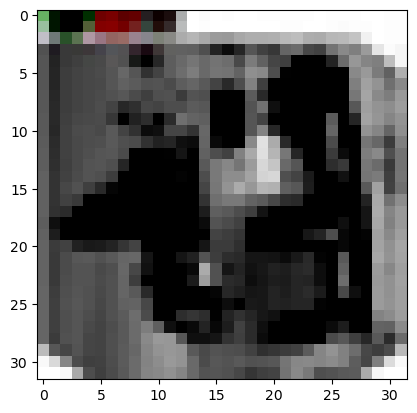

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].


plane


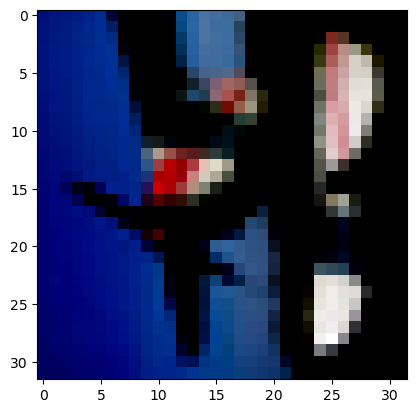

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.96862745].


deer


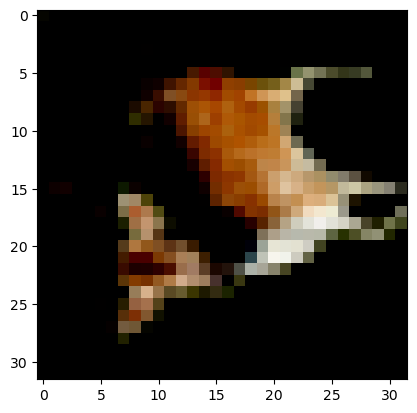

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


ship


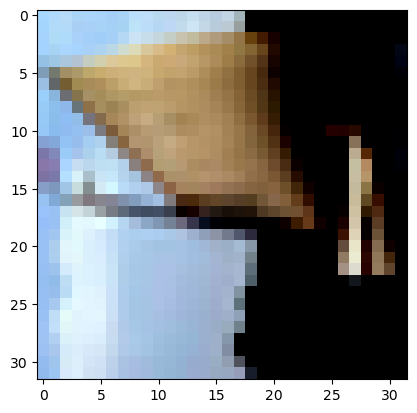

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7176471..1.0].


cat


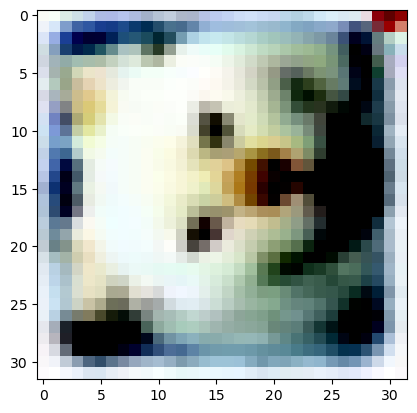

In [34]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

show5(train_loader)

In [35]:
# Explore data
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape) # Batch has 64 samples, 3 channels(r,g,b), and 32x32 shape
print(labels.shape) # Batch has 64 labels

<class 'torch.Tensor'>
torch.Size([5, 3, 32, 32])
torch.Size([5])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [36]:
device =  'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')


class CifarNET(nn.Module):

    conv3_output = 128
    pool_size = conv3_output * 2 * 2
    dropout_size = 0.35

    def __init__(self):
        super(CifarNET, self).__init__()

        self.conv1 = nn.Conv2d(3, 26, 3)
        self.conv2 = nn.Conv2d(26, 56, 3)
        self.conv3 = nn.Conv2d(56, self.conv3_output, 3)

        self.bn1 = nn.BatchNorm2d(26)
        self.bn2 = nn.BatchNorm2d(56)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(self.pool_size, 128)
        self.fc2 = nn.Linear(128, 80)
        self.fc3 = nn.Linear(80, 10)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        #x = F.dropout(x, self.dropout_size)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        #x = F.dropout(x, self.dropout_size)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        #x = F.dropout(x, self.dropout_size)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, self.dropout_size)

        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, self.dropout_size)

        x = self.fc3(x)

        return F.softmax(x, dim=1)


model = CifarNET().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using cuda:0 device


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [37]:
## YOUR CODE HERE ##
print("No less common loss function used")

No less common loss function used


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [38]:
def execute_model_with_loader(epochs=None, mode='train', dataloader=None, results=None):
    """ Generic train/validation/test method. Allows training with or without validation and collect results to the results dict parameters. """
    if mode == 'train' and epochs is None:
        raise ValueError("Number of epochs must be specified for training.")
    elif mode != 'train':
        epochs = 1

    if mode == 'train':
        print(f'Training for {epochs} epochs')

    for epoch in range(epochs):
        if mode == 'train':
            model.train()
        else:
            model.eval()

        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        epoch_dataloader = dataloader

        with torch.set_grad_enabled(mode == 'train'):
            for inputs, labels in epoch_dataloader:
                num_batches += 1
                inputs, labels = inputs.to(device), labels.to(device)

                if mode == 'train':
                    optimizer.zero_grad()

                output = model(inputs)
                loss = criterion(output, labels)

                if mode == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / num_batches
        accuracy = 100 * correct / total if total > 0 else 0

        if mode == 'train':
            results['train']['loss'].append(avg_loss)
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f}')

            if val_loader:
                model.eval()
                execute_model_with_loader(mode='valid', dataloader=val_loader, results=results, epochs=1)
        elif mode == 'valid':
            results['valid']['loss'].append(avg_loss)
            results['valid']['acc'].append(accuracy)

            print(f'Validation Loss: {avg_loss:.4f} | Acc: {accuracy:.3f}%')
        elif mode == 'test':
            results['test']['loss'] = avg_loss
            results['test']['acc'] = accuracy
            print(f'Test Acc: {accuracy:.3f}%')

# Results dict - plot below
model_results = {
    'train': {
        'loss': []
    },
    'valid': {
        'loss': [],
        'acc': []
    }, 'test': {
        'loss': None,
        'acc': None
    }}

Plot the training loss (and validation loss/accuracy, if recorded).

In [39]:
# Train & Validate
execute_model_with_loader(epochs=25, mode='train', dataloader=train_loader, results=model_results)

Training for 25 epochs
Epoch 1/25 | Train Loss: 2.1801
Validation Loss: 2.0332 | Acc: 43.710%
Epoch 2/25 | Train Loss: 2.0222
Validation Loss: 1.9614 | Acc: 49.730%
Epoch 3/25 | Train Loss: 1.9635
Validation Loss: 1.9101 | Acc: 55.070%
Epoch 4/25 | Train Loss: 1.9285
Validation Loss: 1.8824 | Acc: 57.800%
Epoch 5/25 | Train Loss: 1.8998
Validation Loss: 1.8540 | Acc: 60.720%
Epoch 6/25 | Train Loss: 1.8771
Validation Loss: 1.8452 | Acc: 61.570%
Epoch 7/25 | Train Loss: 1.8628
Validation Loss: 1.8404 | Acc: 62.200%
Epoch 8/25 | Train Loss: 1.8484
Validation Loss: 1.8122 | Acc: 64.860%
Epoch 9/25 | Train Loss: 1.8351
Validation Loss: 1.8157 | Acc: 64.170%
Epoch 10/25 | Train Loss: 1.8280
Validation Loss: 1.8150 | Acc: 64.310%
Epoch 11/25 | Train Loss: 1.8176
Validation Loss: 1.8054 | Acc: 65.450%
Epoch 12/25 | Train Loss: 1.8075
Validation Loss: 1.7941 | Acc: 66.510%
Epoch 13/25 | Train Loss: 1.8002
Validation Loss: 1.7926 | Acc: 66.650%
Epoch 14/25 | Train Loss: 1.7937
Validation Loss: 

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

Test Acc: 71.260%


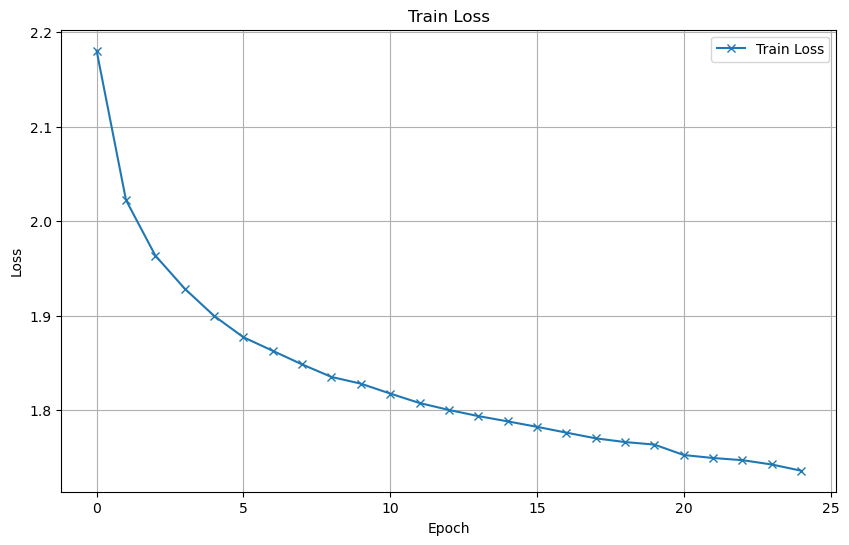

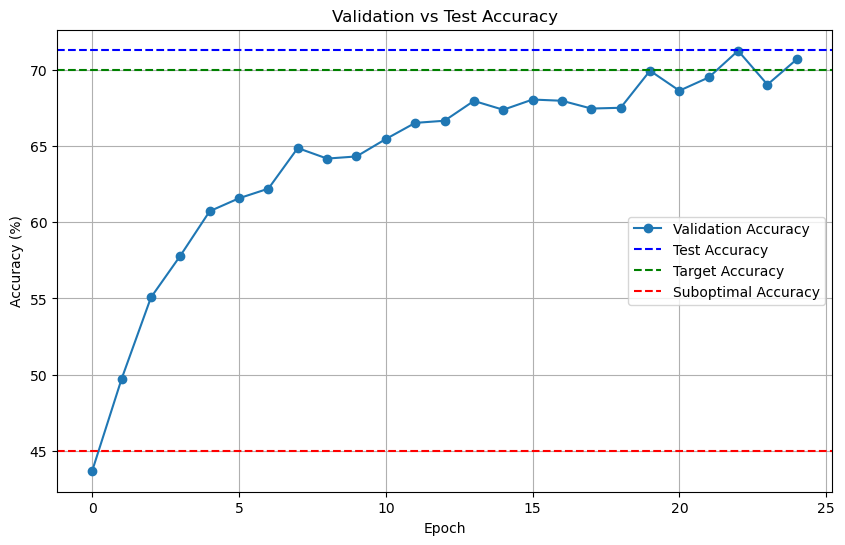

In [40]:
from helper import compare_accuracies, plot_train_loss

# Test
execute_model_with_loader(mode='test', dataloader=test_loader, results=model_results)

# Plotting the results
plot_train_loss(model_results)
compare_accuracies(model_results)

## Saving your model
Using `torch.save`, save your model for future loading.

In [41]:
MODEL_PATH = './u-cifarnet.pth'

torch.save(model.state_dict(), MODEL_PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The model achieve **71.26%** of accuracy during tests, above the minimum required of **45%**. However, there is room for improvements.

Initially, the accuracy with a single convolutional layer, Horizontal Transform and Random Crop Transform was around 54% after the 10th iteration with little to no improvement up to the 25th iteration. Adding extra convolutional layers and batch normalization raised considerably the accuracy. During these tests, I dropped RandomCrop because it decreased the overall accuracy below 65% with a few new extra layers - more tests fine-tuning its parameters might be needed to make better use of transforms for this use case.

While more tests could be done around the current parameters, more research will be needed to introduce a better accuracy. Below I list a few recommendations for future improvements:

* Adding more convolutional layers to extract more features
    * Explore other parameters such as *dilation*
* Tune dropout size for better results
* Experiment new Transforms
    * Fitting extra transforms could help improve the model accuracy
    * Exploring PyTorch Transforms v2 could improve the accuracy as well as GPU performance

In conclusion, considering that the training process took around 30 min to achieve 70% of accuracy and there is room for improvement, I would stick with this current model and invest in improving it. However, if superior accuracy is requested from day one of deployment or ASAP, buying a pre-trained model would be necessary.

The final architecture is presented in the cell below.


In [42]:
from torchsummary import summary

summary(model, (3, 32, 32), 5, 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 26, 30, 30]             728
       BatchNorm2d-2            [5, 26, 30, 30]              52
         MaxPool2d-3            [5, 26, 15, 15]               0
            Conv2d-4            [5, 56, 13, 13]          13,160
       BatchNorm2d-5            [5, 56, 13, 13]             112
         MaxPool2d-6              [5, 56, 6, 6]               0
            Conv2d-7             [5, 128, 4, 4]          64,640
       BatchNorm2d-8             [5, 128, 4, 4]             256
         MaxPool2d-9             [5, 128, 2, 2]               0
           Linear-10                   [5, 128]          65,664
           Linear-11                    [5, 80]          10,320
           Linear-12                    [5, 10]             810
Total params: 155,742
Trainable params: 155,742
Non-trainable params: 0
-------------------------------

### References

* Udacity [Introduction to Machine Learning with Pytorch
](https://www.udacity.com/course/intro-to-machine-learning-nanodegree--nd229)
* Pytorch Official Documentation
    * [Training Classifiers](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
    * [Transforms](https://pytorch.org/vision/main/transforms.html)
    * [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
    * [Loading and Saving Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
    * [Torchsummary](https://pypi.org/project/torch-summary/)